In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT

sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic

## Import uniqueInchikey subset (positive ionization mode)

# Import and filter MS-MS data from MGF file

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
#### 1. Discard spectra with too few peaks.
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

#### 2. Filter out noise. 
This can be done by:
#### A) Exponential peak intensity filter 
Further filtering is done to reduce the level of noise in the spectra. For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  
**But keep enough information:** Aimed at similar sized documents: If the number of peaks above the set threshold is lower than $n_{aim}$ = min_peaks + peaks_per_mz * precursor_mass we will at least keep the highest $n_{aim}$ peaks.

#### B) Relative peak intensity filter
This is a simpler filter which will discard all peaks with an intensity < min_intensity_perc/100 * max_peak_intensity.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [2]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json")
file_mgf = os.path.join(PATH_MS_DATA, "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [3]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


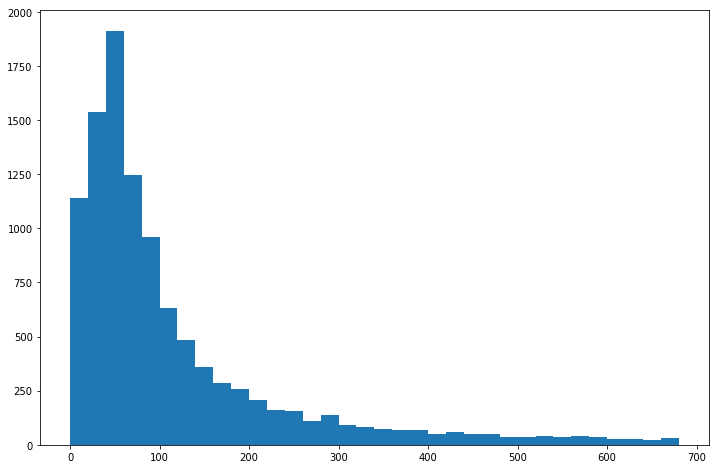

In [4]:
num_peaks = []
for spec in spectra:
    num_peaks.append(spec.n_peaks)
    
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
a = plt.hist(num_peaks, np.arange(0,700,20))

# Switch to Spec2Vec core functionality

In [8]:
MS_library = SimilarityMeasures(MS_documents, MS_documents_intensity)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

Preprocess documents...
Number of unique words:  116344


### Train a Spec2Vec model based on uniqueInchikey subset

In [9]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter100_TEMP_15.model')
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [15], 
                             use_stored_model=True)

Load stored word2vec model ...


In [10]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  documents.2500  of  10998  documents.  of  10998  documents. 10998  documents. of  10998  documents. documents. 10260  of  10998  documents.

### Calculate all-vs-all similarity matrix based on Spec2Vec spectra vectors

In [12]:
from scipy import spatial

# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_library.vectors_centroid, MS_library.vectors_centroid, 'cosine')

In [13]:
#np.save(PATH_SAVE_MODEL + 'M_sim_spec2vec_uI_model_tfidf_191110.npy', M_sim_ctr)
np.save(os.path.join(PATH_COMPUTED, 'M_sim_spec2vec_uI_model_200219.npy'), M_sim_ctr)

In [37]:
M_sim_ctr = np.load(os.path.join(PATH_SAVE_MODEL, 'M_sim_spec2vec_uI_model_200219.npy'))

In [14]:
M_sim_ctr.shape

(10998, 10998)

## Compare to model trained on allGNPS_positive

In [16]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'S2V_allGNPS_pos_removed0_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_15.model')
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [15], 
                             use_stored_model=True)

Load stored word2vec model ...


In [17]:
# Use peak intensities as extra weights
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.0998  documents.10998  documents. 10998  documents.  documents. Calculated centroid vectors for  8550  of  10998  documents. of  10998  documents.  of  10998  documents.

In [18]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_all = 1 - spatial.distance.cdist(MS_library.vectors_centroid, MS_library.vectors_centroid, 'cosine')

In [20]:
np.save(os.path.join(PATH_COMPUTED, 'M_sim_spec2vec_uI_allGNPS_pos_model_200219.npy'), M_sim_ctr_all)

In [21]:
M_sim_ctr_all.shape

(10998, 10998)

---
# Compare to reference scores based on molecular fingerprints

In [22]:
from plotting_functions import plot_precentile

In [24]:
filename = os.path.join(PATH_COMPUTED, 'MS_sim_mol_uniqueInchikey_morgan3_dice2048_191119.npy')
mol_sim_morgan3 = MS_sim_classic.mol_sim_matrix([],
                                                [],
                                                method = 'dice',
                                                filename = filename)

Molecular similarity scores found and loaded.


In [ ]:
filename = os.path.join(PATH_COMPUTED, 'MS_sim_mol_uniqueInchikey_rdkit2048_jaccard_191119.npy')
mol_sim_rdkit = MS_sim_classic.mol_sim_matrix([],
                                                [],
                                                method = 'jaccard',
                                                filename = filename)

In [26]:
# pass on IDs for which fingerprint could not be calculated:
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

In [27]:
scores = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = scores.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
scores = np.delete(scores.reshape(length**2), remove_diagonal)

scores_ref = np.delete(np.delete(mol_sim_morgan3, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
scores_ref = np.delete(scores_ref.reshape(length**2), remove_diagonal)

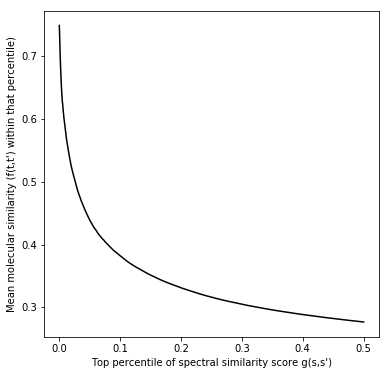

In [28]:
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice = plot_precentile(scores, scores_ref, num_bins = 1000 , show_top_percentile = 0.5)
np.save(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_uI-pos_morgan3_2048_dice_200219.npy'), 
        ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice)

In [29]:
scores = np.delete(np.delete(M_sim_ctr_all, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = scores.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
scores = np.delete(scores.reshape(length**2), remove_diagonal)

scores_ref = np.delete(np.delete(mol_sim_morgan3, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
scores_ref = np.delete(scores_ref.reshape(length**2), remove_diagonal)

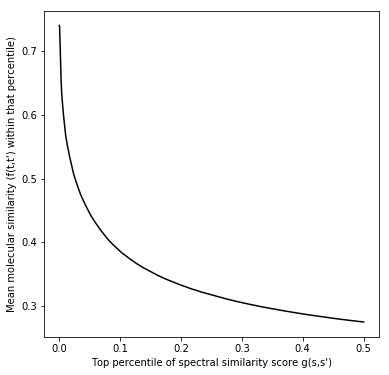

In [31]:
ref_score_Spec2Vec_gnpsALL_pos_morgan3_dice = plot_precentile(scores, scores_ref, num_bins = 1000 , show_top_percentile = 0.5)
np.save(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_gnpsALL-pos_morgan3_2048_dice_200219.npy'), 
        ref_score_Spec2Vec_gnpsALL_pos_morgan3_dice)

# Compare different benchmarks in one graph

In [41]:
#ref_score_best_modcos = np.load(os.path.join(PATH_COMPUTED,'spec2vec_uniquesmiles_pos_ModCos_min_match_14.npy'))
ref_score_best_modcos = np.load(os.path.join(PATH_COMPUTED,'Benchmarks_uniquesmiles_pos_exp08_filter_ModCos_min_match_16.npy'))
ref_score_best_modcos_min_match6 = np.load(os.path.join(PATH_COMPUTED,'Benchmarks_uniquesmiles_pos_exp08_filter_ModCos_min_match_6.npy'))


ref_score_best_cosine = np.load(os.path.join(PATH_COMPUTED,'Benchmarks_uniquesmiles_pos_exp08_filter_Cosine_min_match_6.npy'))

ref_score_S2V_uniqueInchikey = np.load(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_uI-pos_morgan3_2048_dice_200219.npy'))
ref_score_S2V_allGNPS = np.load(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_gnpsALL-pos_morgan3_2048_dice_200219.npy'))



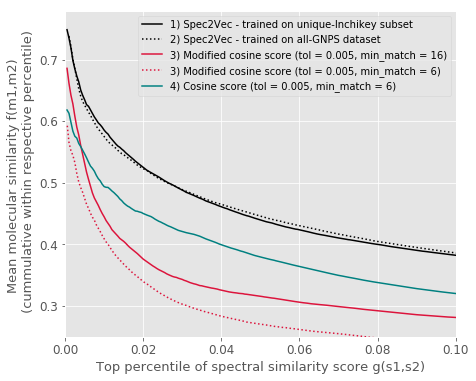

In [54]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_S2V_uniqueInchikey, 
         color='black',
         label='1) Spec2Vec - trained on unique-Inchikey subset')
         #Model: unique_inchikey \n (min_peaks=10, exp filter 0.8, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1],ref_score_S2V_allGNPS, 
         ':', color='black',
         label='2) Spec2Vec - trained on all-GNPS dataset')
         # - Model: allGNPS \n (min_peaks=10, 0.1 perc filter, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_best_modcos, 
         color='crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 16)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_best_modcos_min_match6, 
         ':', color='crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 6)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_best_cosine, 
         color='teal', #'gold',
         label='4) Cosine score (tol = 0.005, min_match = 6)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uI_allGNPSmodel_pos_morgan3_dice, 
#         '--', color='darkblue',
#         label='Spec2Vec - Model: all GNPS (no retrain) \n (min_peaks=10, 0.1 perc filter, iter=100, dim=300)')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (cummulative within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig('Benchmarking_top_percentil_comparison_200219.pdf')

# 2. Load modified cosine scores for all-vs all spectra

In [6]:
import MS_similarity_classical as MS_sim_classic

filename = os.path.join(PATH_COMPUTED, 'modcos_scores_uniqueInchikey_pos_191107_minperc05_tol0005.npy')
M_modcos_sim_greedy, M_modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 25)

Complete cosine similarity scores found and loaded.


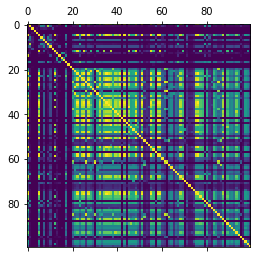

In [23]:
plt.matshow(M_modcos_sim_greedy[:100,:100])

# 3. Calculate molecular similarities based on molecular fingerprints
## Calculate molecular fingerprints

### Compute all-vs-all matrix of Dice similarities

In [8]:
import MS_similarity_classical as MS_sim_classic

filename = os.path.join(PATH_COMPUTED, 'M_mol_sim_uniqueInchikey_pos_191110_morgan3_dice.npy')
M_sim_mol = MS_sim_classic.mol_sim_matrix([], #fingerprints_morgan3_2048,
                                       [], #fingerprints_morgan3_2048,
                                       method = 'dice',
                                       filename = filename)

Molecular similarity scores found and loaded.


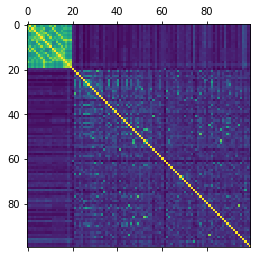

In [24]:
# morgan3_2048_dice
plt.matshow(M_sim_mol[:100,:100])

In [9]:
# Find bette way to keep track of wrong fingerprints!!
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

# 4. Use molecular similarity scores for benchmarking
### Explore the influcence of min_match on mod.cosine score performance:

In [28]:
ref_score_cum_modcos_minmatch14 = np.load('spec2vec_uniquesmiles_pos_ModCos_min_match_14.npy')

### Compare Spec2Vec vs molecular similarity

In [10]:
from plotting_functions import plot_precentile

In [39]:
A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = A.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
A = np.delete(A.reshape(length**2), remove_diagonal)

#B = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
#B = np.delete(B.reshape(length**2), remove_diagonal)

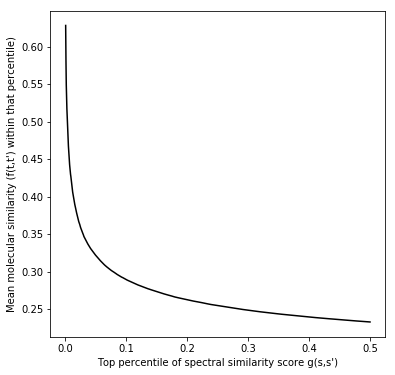

In [40]:
from matplotlib import pyplot as plt

ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
np.save(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_2048_dice.npy'), 
        ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice)

In [47]:
A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = A.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
A = np.delete(A.reshape(length**2), remove_diagonal)

#B = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
#B = np.delete(B.reshape(length**2), remove_diagonal)

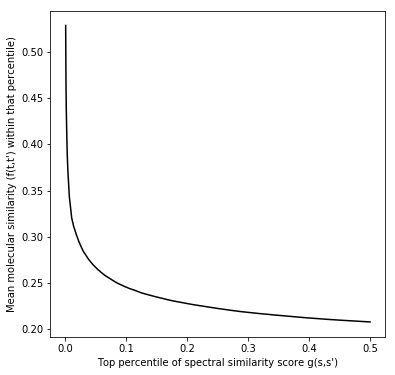

In [48]:
ref_score_Spec2Vec_uI_allGNPSmodel_pos_morgan3_dice = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
np.save(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_uI_allGNPSmodel_pos_morgan3_2048_dice.npy'), 
        ref_score_Spec2Vec_uI_allGNPSmodel_pos_morgan3_dice)

In [65]:
ref_score_cum_modcos_minmatch14 = np.load('spec2vec_uniquesmiles_pos_ModCos_min_match_14.npy')
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice = np.load(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_2048_dice.npy')
ref_score_Spec2Vec_uniqueInchikey_pos_exp08_morgan3_dice = np.load('ref_score_Spec2Vec_uniqueInchikey_pos_exp08_morgan3_dice.npy')

ref_score_Spec2Vec_uImodel_times_modcos10_morgan3_2048_dice = np.load('ref_score_Spec2Vec_uImodel_times_modcos10_morgan3_2048_dice.npy')

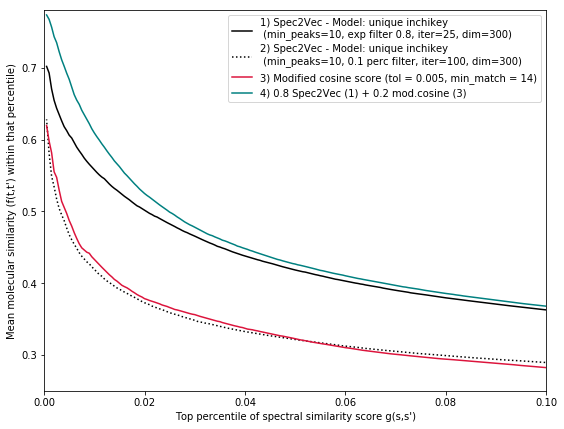

In [19]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(9,7))

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_exp08_morgan3_dice, 
         color='black',
         label='1) Spec2Vec - Model: unique inchikey \n (min_peaks=10, exp filter 0.8, iter=25, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice, 
         ':', color='black',
         label='2) Spec2Vec - Model: unique inchikey \n (min_peaks=10, 0.1 perc filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         color='crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 14)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uImodel_times_modcos10_morgan3_2048_dice, 
         color='teal', #'gold',
         label='4) 0.8 Spec2Vec (1) + 0.2 mod.cosine (3)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uI_allGNPSmodel_pos_morgan3_dice, 
#         '--', color='darkblue',
#         label='Spec2Vec - Model: all GNPS (no retrain) \n (min_peaks=10, 0.1 perc filter, iter=100, dim=300)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig('Top_percentile_uniqueInchikey_pos_191110.pdf')

In [20]:
ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter25_morgan3_dice = np.load('ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter25_morgan3_dice.npy')
ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter50_morgan3_dice = np.load('ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter50_morgan3_dice.npy')
ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter75_morgan3_dice = np.load('ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter75_morgan3_dice.npy')
ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter100_morgan3_dice = np.load('ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter100_morgan3_dice.npy')

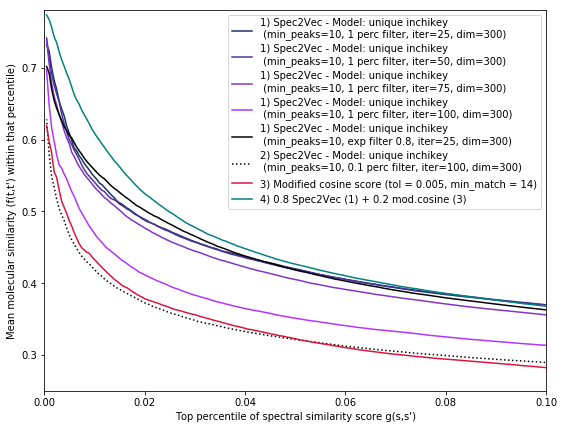

In [27]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(9,7))

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter25_morgan3_dice, 
         color= (0.1, 0.2, 0.4),
         label='1) Spec2Vec - Model: unique inchikey \n (min_peaks=10, 1 perc filter, iter=25, dim=300)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter50_morgan3_dice, 
         color=(0.3, 0.2, 0.6),
         label='1) Spec2Vec - Model: unique inchikey \n (min_peaks=10, 1 perc filter, iter=50, dim=300)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter75_morgan3_dice, 
         color=(0.5, 0.2, 0.8),
         label='1) Spec2Vec - Model: unique inchikey \n (min_peaks=10, 1 perc filter, iter=75, dim=300)')
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_minperc1_iter100_morgan3_dice, 
         color=(0.7, 0.2, 1.0),
         label='1) Spec2Vec - Model: unique inchikey \n (min_peaks=10, 1 perc filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_exp08_morgan3_dice, 
         color='black',
         label='1) Spec2Vec - Model: unique inchikey \n (min_peaks=10, exp filter 0.8, iter=25, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice, 
         ':', color='black',
         label='2) Spec2Vec - Model: unique inchikey \n (min_peaks=10, 0.1 perc filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         color='crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 14)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uImodel_times_modcos10_morgan3_2048_dice, 
         color='teal', #'gold',
         label='4) 0.8 Spec2Vec (1) + 0.2 mod.cosine (3)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uI_allGNPSmodel_pos_morgan3_dice, 
#         '--', color='darkblue',
#         label='Spec2Vec - Model: all GNPS (no retrain) \n (min_peaks=10, 0.1 perc filter, iter=100, dim=300)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig('Top_percentile_uniqueInchikey_pos_iter_test_191111.pdf')

In [29]:
ref_score_Spec2Vec_allGNPS_pos_exp08_morgan3_dice_lst = []

iterations = 10*[10]
iterations = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]
for iter in iterations:
    ref_score_Spec2Vec = np.load(PATH_COMPUTED + 'ref_score_Spec2Vec_allGNPS_pos_exp08_iter' + str(iter) + '_morgan3_dice.npy')
    ref_score_Spec2Vec_allGNPS_pos_exp08_morgan3_dice_lst.append(ref_score_Spec2Vec)

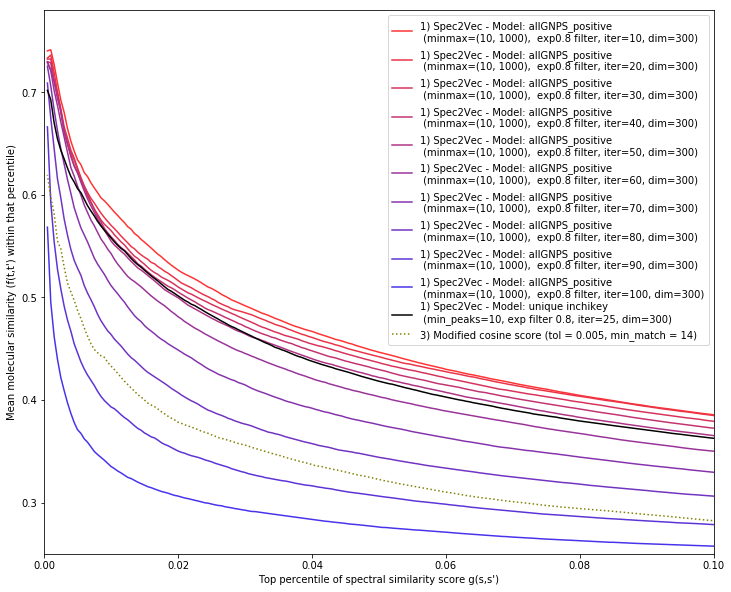

In [39]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))

for i, iter in enumerate(iterations):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_allGNPS_pos_exp08_morgan3_dice_lst[i], 
             color= ((1-0.08*i), 0.2, 0.08*i+0.2),
             label='1) Spec2Vec - Model: allGNPS_positive \n (minmax=(10, 1000),  exp0.8 filter, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_exp08_morgan3_dice, 
         color='black',
         label='1) Spec2Vec - Model: unique inchikey \n (min_peaks=10, exp filter 0.8, iter=25, dim=300)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice, 
#         ':', color='black',
#         label='2) Spec2Vec - Model: unique inchikey \n (min_peaks=10, 0.1 perc filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='olive', #'crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 14)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uImodel_times_modcos10_morgan3_2048_dice, 
#         color='teal', #'gold',
#         label='4) 0.8 Spec2Vec (1) + 0.2 mod.cosine (3)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig('Top_percentile_allGNPS_pos_iter_test_191112.pdf')

In [40]:
ref_score_Spec2Vec_allGNPS_pos_minperc1_morgan3_dice_lst = []

iterations = 10*[10]
iterations = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]
for iter in iterations:
    ref_score_Spec2Vec = np.load(PATH_COMPUTED + 'ref_score_Spec2Vec_allGNPS_pos_minperc1_iter' + str(iter) + '_morgan3_dice.npy')
    ref_score_Spec2Vec_allGNPS_pos_minperc1_morgan3_dice_lst.append(ref_score_Spec2Vec)
    

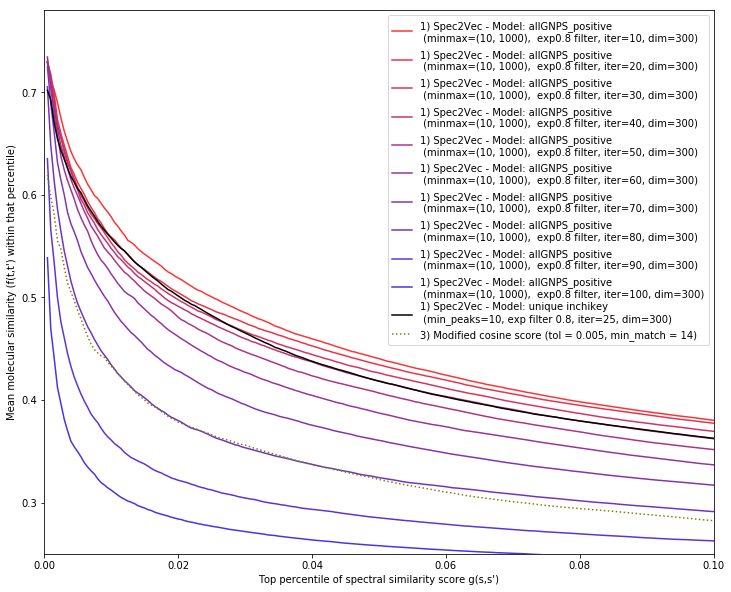

In [41]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))

for i, iter in enumerate(iterations):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_allGNPS_pos_minperc1_morgan3_dice_lst[i], 
             color= ((1-0.08*i), 0.2, 0.08*i+0.2),
             label='1) Spec2Vec - Model: allGNPS_positive \n (minmax=(10, 1000),  exp0.8 filter, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_exp08_morgan3_dice, 
         color='black',
         label='1) Spec2Vec - Model: unique inchikey \n (min_peaks=10, exp filter 0.8, iter=25, dim=300)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice, 
#         ':', color='black',
#         label='2) Spec2Vec - Model: unique inchikey \n (min_peaks=10, 0.1 perc filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='olive', #'crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 14)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uImodel_times_modcos10_morgan3_2048_dice, 
#         color='teal', #'gold',
#         label='4) 0.8 Spec2Vec (1) + 0.2 mod.cosine (3)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig('Top_percentile_allGNPS_pos_minperc1_iter_test_191112.pdf')

# Testing Gensim parameters for word2vec model

Some semi worked out observations.  
+ A skip-gram model did not work better for me than a CBOW model (which is what was used by us until now).   
+ The loss given by Gensim seems to diverge! Not sure why? --> probably gensim gives cummulative loss!
+ cbow_mean = 0 did not improve things.
+ 

In [3]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191110.json")
file_mgf = os.path.join(PATH_MS_DATA, "allGNPS_positive_uniqueInchikey_191107.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [4]:
from similarity_measure import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)
MS_measure.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  116344


Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.alculated centroid vectors for  440  of  10998  documents.  of  10998  documents. documents.  of  10998  documents.10998  documents. Calculated centroid vectors for  9330  of  10998  documents. of  10998  documents. of  10998  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  documents.1780  of  10998  documents. 4080  of  10998  documents. 5240  of  10998  documents. of  10998  documents. Calculated centroid vectors for  6850  of  10998  documents. 10998  documents. 9850  of  10998  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  docume

TypeError: 'int' object is not iterable

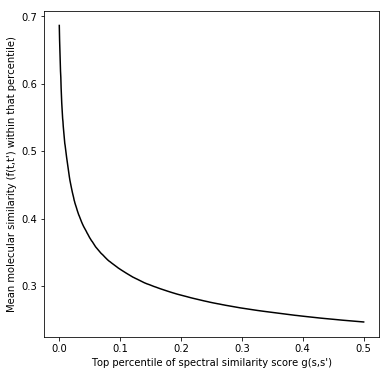

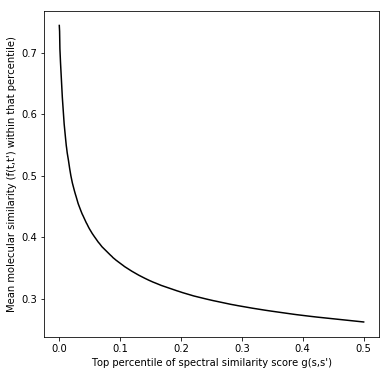

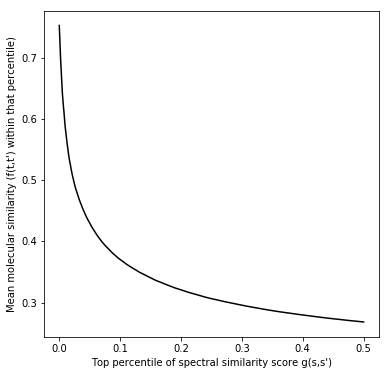

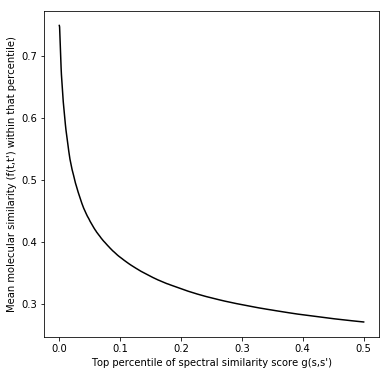

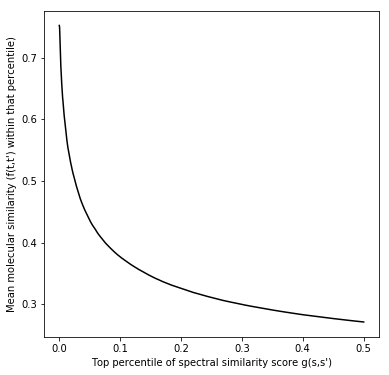

In [61]:
ref_score_Spec2Vec_tests_lst = []

iterations = 10*[2]
iterations = [int(x + np.sum(iterations[:i])) for i, x in enumerate(iterations)]
filename_base = PATH_SAVE_MODEL + 'just_testing_neg20_TEMP_'
filenames = [filename_base + str(x) + '.model' for x in iterations]
filenames.extend([filename_base + '.model'])

for i, filename in enumerate(filenames):
    MS_measure.build_model_word2vec(filename, size=300, window=500, 
                             min_count=1, workers=4, iterations=iterations[0], 
                             use_stored_model=True)
    
    MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = False, #True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)
    
    M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')
    np.save(os.path.join(PATH_COMPUTED, 'M_sim_just_testing_neg20_TEMP_' + str(iterations[i]) + '_191113.npy'), M_sim_ctr)
    
    A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
    A = np.delete(A.reshape(length**2), remove_diagonal)
    
    # Plot against dice score on morgan3 fingerprints   
    ref_score_Spec2Vec = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
    ref_score_Spec2Vec_tests_lst.append(ref_score_Spec2Vec)
    np.save(os.path.join(PATH_COMPUTED, 'ref_score_just_testing_neg20_TEMP_' + str(iterations[i]) + '_morgan3_dice.npy'), ref_score_Spec2Vec)
    

Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.documents. 10998  documents.  documents. 10998  documents. documents.  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.10998  documents.10998  documents. of  10998  documents. Calculated centroid vectors for  7610  of  10998  documents. of  10998  documents.10390  of  10998  documents.Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  documents.  documents.  documents.  documents. of  10998  documents. of  10998  documents. documents.  of  10998  documents.  of  10998  documents. 10998  documents.  of  10998  documents. of  10998  documents. documents.Load st

TypeError: 'int' object is not iterable

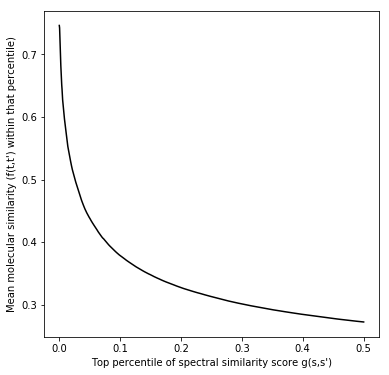

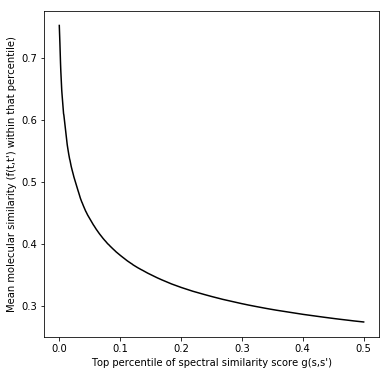

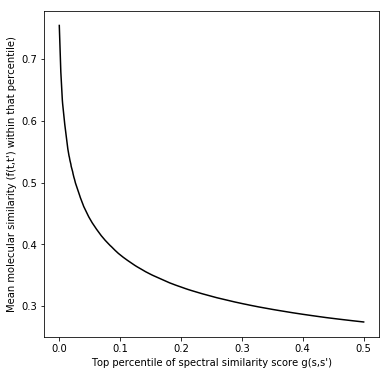

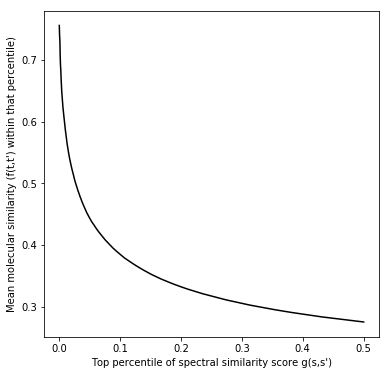

In [72]:
for i, filename in enumerate(filenames[5:]):
    MS_measure.build_model_word2vec(filename, size=300, window=500, 
                             min_count=1, workers=4, iterations=iterations[0], 
                             use_stored_model=True)
    
    MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = False, #True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)
    
    M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')
    np.save(os.path.join(PATH_COMPUTED, 'M_sim_just_testing_neg20_TEMP_' + str(iterations[5+i]) + '_191113.npy'), M_sim_ctr)
    
    A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
    A = np.delete(A.reshape(length**2), remove_diagonal)
    
    # Plot against dice score on morgan3 fingerprints   
    ref_score_Spec2Vec = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
    ref_score_Spec2Vec_tests_lst.append(ref_score_Spec2Vec)
    np.save(os.path.join(PATH_COMPUTED, 'ref_score_just_testing_neg20_TEMP_' + str(iterations[5+i]) + '_morgan3_dice.npy'), ref_score_Spec2Vec)
    

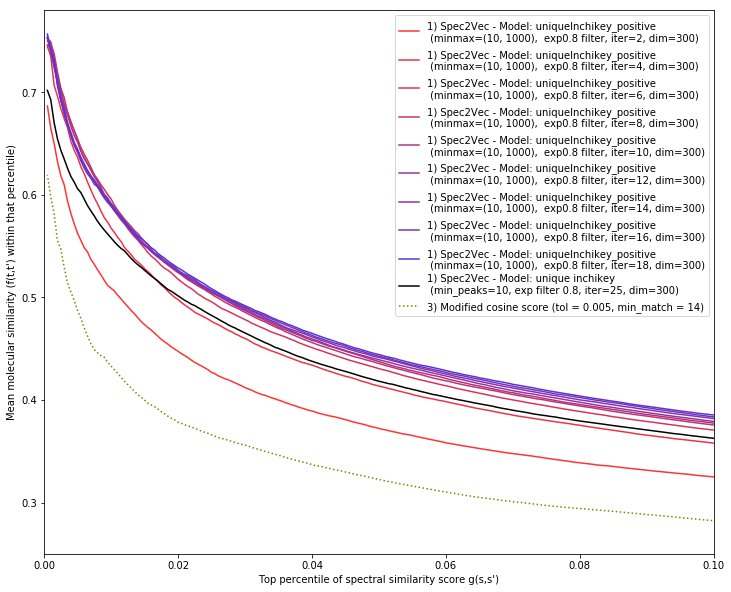

In [75]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))

for i, iter in enumerate(iterations[:9]):
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst[i], 
             color= ((1-0.08*i), 0.2, 0.08*i+0.2),
             label='1) Spec2Vec - Model: uniqueInchikey_positive \n (minmax=(10, 1000),  exp0.8 filter, iter='+str(iter)+', dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_exp08_morgan3_dice, 
         color='black',
         label='1) Spec2Vec - Model: unique inchikey \n (min_peaks=10, exp filter 0.8, iter=25, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='olive', #'crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 14)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig('Top_percentile_testing_gensim_parameters_191113.pdf')

In [50]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'just_testing_cbowsum_TEMP_14.model')
MS_measure.build_model_word2vec(file_model_word2vec, sg=1, size=300, window=500, 
                             min_count=1, workers=4, iterations=2, 
                             use_stored_model=True)

Load stored word2vec model ...


In [33]:
MS_measure.model_word2vec.cbow_mean

0

In [51]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = False, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.f  10998  documents. Calculated centroid vectors for  320  of  10998  documents.  documents.1440  of  10998  documents.  of  10998  documents. 3140  of  10998  documents. of  10998  documents. Calculated centroid vectors for  8290  of  10998  documents. documents.10998  documents.

In [52]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

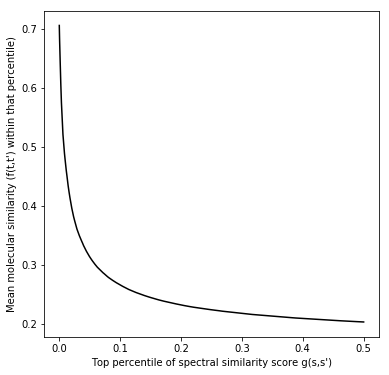

In [53]:
A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = A.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
A = np.delete(A.reshape(length**2), remove_diagonal)

#B = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
#B = np.delete(B.reshape(length**2), remove_diagonal)

from matplotlib import pyplot as plt
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
np.save(PATH_COMPUTED + 'ref_score_Spec2Vec_uniqueInchikey_pos_SGNS_morgan3_2048_dice_cbowsum14.npy', 
        ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice)

In [54]:
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice[::-1][::100] #iter14 cbowmean=1

array([0.70541523, 0.31299442, 0.26560741, 0.24437312, 0.23186443,
       0.22356323, 0.21740779, 0.21263348, 0.20881718, 0.20561316])

In [49]:
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice[::-1][::100] #iter6 cbowmean=1

array([0.68966294, 0.34463691, 0.29867249, 0.27418256, 0.25846899,
       0.24748794, 0.23905557, 0.23217271, 0.22661939, 0.22200686])

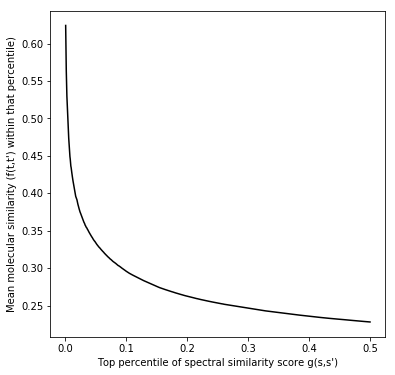

In [36]:
A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = A.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
A = np.delete(A.reshape(length**2), remove_diagonal)

#B = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
#B = np.delete(B.reshape(length**2), remove_diagonal)

from matplotlib import pyplot as plt
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
np.save(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_uniqueInchikey_pos_SGNS_morgan3_2048_dice_cbowsum2.npy'), 
        ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice)

In [44]:
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice[::-1][::100] #iter2 cbowmean=1

array([0.62409022, 0.33332624, 0.29569725, 0.27565646, 0.2625405 ,
       0.25357124, 0.24669017, 0.24074019, 0.23603563, 0.2319483 ])

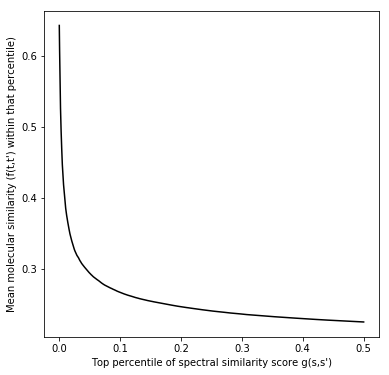

In [15]:
A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = A.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
A = np.delete(A.reshape(length**2), remove_diagonal)

#B = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
#B = np.delete(B.reshape(length**2), remove_diagonal)

from matplotlib import pyplot as plt
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
np.save(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_uniqueInchikey_pos_SGNS_morgan3_2048_dice_test.npy'), 
        ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice)

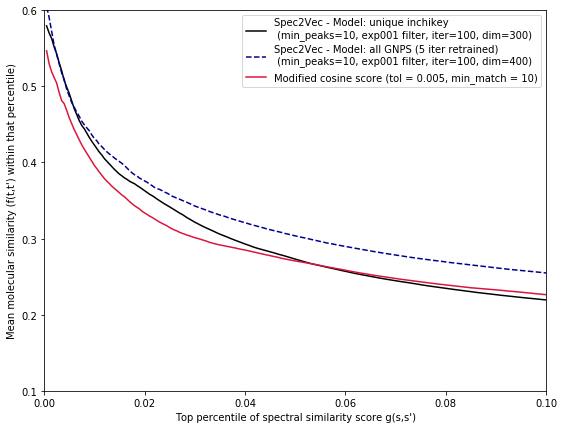

In [182]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(9,7))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_jaccard, 
         color='black',
         label='Spec2Vec - Model: unique inchikey \n (min_peaks=10, exp001 filter, iter=100, dim=300)')

"""plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_allGNPS_times_modcos10_0_morgan3_jaccard, 
         color='gold',
         label='Spec2Vec * mod.cosine \n - Model: all GNPS (5 iter retrained) \n (min_peaks=2, exp001 filter, iter=100, dim=300)')
"""
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_allGNPS_minmatch10_morgan3_jaccard, 
         '--', color='darkblue',
         label='Spec2Vec - Model: all GNPS (5 iter retrained) \n (min_peaks=10, exp001 filter, iter=100, dim=400)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_collection_jaccard[11], 
         color='crimson',
         label='Modified cosine score (tol = 0.005, min_match = 10)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.1, 0.6)
plt.savefig('Top_percentile_uniqueInchikey_pos_jaccard.pdf')

In [184]:
B.mean(), B_jaccard.mean()

(0.16804089076277584, 0.09318770570734611)

### Use Spec2Vec model trained on allGNPS dataset

In [158]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'model_MS_allGNPS_d300_w500_iter100_loss500_minpeak2_dec2_exp001.model')
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [159]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'model_MS_allGNPS_d400_w500_iter100_loss500_minpeak10_dec2_exp001.model')
MS_measure.build_model_word2vec(file_model_word2vec, size=400, window=500, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [160]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore'
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
12  out of  78249  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.


2019-11-07 13:56:54,081 : WARNING : Effective 'alpha' higher than previous training cycles


 Epoch  105  of  100 .Using present tfidf model.
  Calculated centroid vectors for  11017  of  11017  documents.f  11017  documents. Calculated centroid vectors for  1060  of  11017  documents. 1550  of  11017  documents.1790  of  11017  documents. 11017  documents. 2490  of  11017  documents. of  11017  documents. 11017  documents. 11017  documents. 3820  of  11017  documents. 11017  documents.  documents.11017  documents. of  11017  documents. 11017  documents.11017  documents.  of  11017  documents. 6150  of  11017  documents. 6390  of  11017  documents. of  11017  documents.7770  of  11017  documents. 11017  documents. 8140  of  11017  documents. 8200  of  11017  documents. 8650  of  11017  documents. 8850  of  11017  documents.9090  of  11017  documents. of  11017  documents. of  11017  documents.10520  of  11017  documents.10640  of  11017  documents.  documents.

In [161]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [164]:
A_all = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = A_all.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
A_all = np.delete(A_all.reshape(length**2), remove_diagonal)

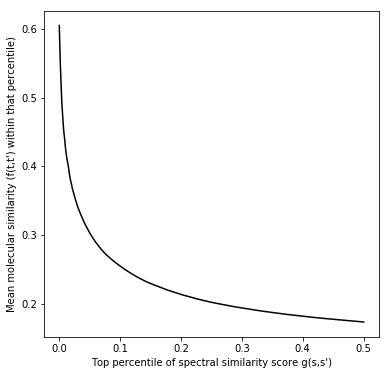

In [165]:
ref_score_Spec2Vec_allGNPS_minmatch10_morgan3_jaccard = plot_precentile(A_all, B_jaccard, num_bins = 1000 , show_top_percentile = 0.5)
np.save('ref_score_Spec2Vec_allGNPS_minmatch10_morgan3_jaccard.npy', ref_score_Spec2Vec_allGNPS_minmatch10_morgan3_jaccard)

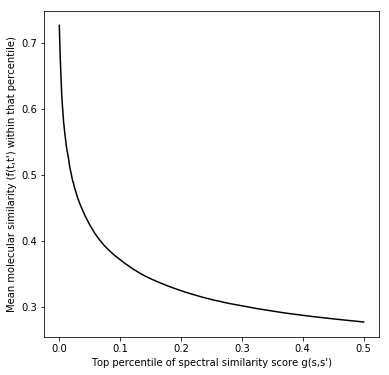

In [166]:
ref_score_Spec2Vec_allGNPS_minmatch10_morgan3_dice = plot_precentile(A_all, B, num_bins = 1000 , show_top_percentile = 0.5)
np.save('ref_score_Spec2Vec_allGNPS_minmatch10_morgan3_dice.npy', ref_score_Spec2Vec_allGNPS_minmatch10_morgan3_dice)

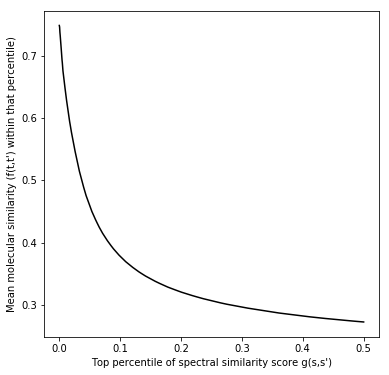

In [168]:
M_sim_modcos = modcos_sim_greedy * (modcos_matches_greedy > 9)
M_sim_modcos = np.delete(np.delete(M_sim_modcos, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
A_modcos = np.delete(M_sim_modcos.reshape(length**2), remove_diagonal)  

ref_score_Spec2Vec_allGNPS_times_modcos10_0_morgan3_dice = plot_precentile(A_all*A_modcos, B, num_bins = 1000 , show_top_percentile = 0.5)
np.save('ref_score_Spec2Vec_allGNPS_times_modcos10_0_morgan3_dice.npy', ref_score_Spec2Vec_allGNPS_times_modcos10_0_morgan3_dice)

In [215]:
ref_score_Spec2Vec_allGNPS_minmatch10_RDkit_dice = plot_precentile(A_all, B_rdkit, num_bins = 1000 , show_top_percentile = 0.5)
np.save('ref_score_Spec2Vec_allGNPS_minmatch10_RDkit_dice.npy', ref_score_Spec2Vec_allGNPS_minmatch10_RDkit_dice)

NameError: name 'B_rdkit' is not defined

In [28]:
ref_score_ModCos_minmatch10_tol0005 = np.load('spec2vec_uniquesmiles_ModCos_min_match_10.npy')

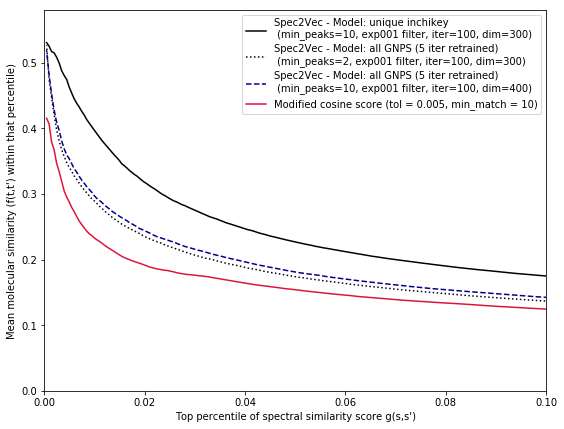

In [128]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(9,7))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uniqueInchikey, 
         color='black',
         label='Spec2Vec - Model: unique inchikey \n (min_peaks=10, exp001 filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_allGNPS, 
         ':', color='black',
         label='Spec2Vec - Model: all GNPS (5 iter retrained) \n (min_peaks=2, exp001 filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_allGNPS_minmatch10, 
         '--', color='darkblue',
         label='Spec2Vec - Model: all GNPS (5 iter retrained) \n (min_peaks=10, exp001 filter, iter=100, dim=400)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_ModCos_minmatch10_tol0005, 
         color='crimson',
         label='Modified cosine score (tol = 0.005, min_match = 10)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.0, 0.58)
plt.savefig('Top_percentile_uniqueInchikey_vs_allGNPS.pdf')

# Additional test of modified cosine score functions

In [4]:
import MS_similarity_classical as MS_sim_classic

### Now there is 3 ways to compute the modified cosine scores.
1. Greedy method (mostly taken from Simon)
2. Greedy method + some parts compiled using Numba.
3. More precise Hungarian algorithm + using Numba.

In [5]:
%%time
modcos_sim0, modcos_matches0 = MS_sim_classic.cosine_score_matrix(spectra[:1000], 
                  tol = 0.005, 
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy', 
                  num_workers = 4,
                  filename = None, #'testing_molent_new.npy',
                  safety_points = None)

print('\n' + 40 * '-')

Calculate pairwise scores by  4 number of workers.
  Calculated MolNet for pair  968 -- 995 . (  100.0  % done).
----------------------------------------
Wall time: 3min 16s


In [6]:
%%time
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra[:1000], 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = None, #'testing_molent_new.npy',
                  safety_points = None)

print('\n' + 40 * '-')

Calculate pairwise scores by  4 number of workers.
  Calculated MolNet for pair  968 -- 995 . (  100.0  % done).lculated MolNet for pair  20 -- 209 . (  4.0  % done). 24 -- 299 . (  4.8  % done). 377 . (  10.2  % done).769 . (  11.6  % done). Calculated MolNet for pair  61 -- 890 . (  12.0  % done).71 -- 555 . (  13.8  % done).. (  15.2  % done). % done).. (  19.4  % done).-- 625 . (  23.2  % done).-- 729 . (  26.0  % done). -- 730 . (  27.2  % done). -- 909 . (  36.8  % done). % done). -- 639 . (  44.6  % done).258 -- 410 . (  45.0  % done). -- 469 . (  48.8  % done).. (  53.4  % done).-- 627 . (  54.8  % done).429 . (  59.6  % done).376 -- 875 . (  61.2  % done). -- 770 . (  61.8  % done).535 . (  62.0  % done). 435 . (  65.0  % done).. (  67.8  % done). 451 -- 925 . (  70.0  % done).. (  71.6  % done).-- 574 . (  72.4  % done). 73.2  % done).  % done). 526 -- 600 . (  77.6  % done). . (  78.0  % done). Calculated MolNet for pair  552 -- 627 . (  80.0  % done).
----------------------

In [7]:
%%time
modcos_sim, modcos_matches = MS_sim_classic.cosine_score_matrix(spectra[:1000], 
                  tol = 0.005, 
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='hungarian', 
                  num_workers = 4,
                  filename = None, #'testing_molent_new.npy',
                  safety_points = None)

print('\n' + 40 * '-')

Calculate pairwise scores by  4 number of workers.
  Calculated MolNet for pair  968 -- 995 . (  100.0  % done).9 . (  8.0  % done). 127 . (  9.2  % done). . (  12.6  % done).67 -- 277 . (  13.0  % done). -- 700 . (  14.2  % done).14.4  % done). % done).655 . (  18.4  % done).98 -- 850 . (  18.8  % done). 103 -- 355 . (  19.6  % done). -- 785 . (  22.0  % done).. (  22.6  % done). 384 . (  24.2  % done). 132 -- 777 . (  24.8  % done). 25.4  % done). 452 . (  25.6  % done). % done).. (  30.4  % done). -- 364 . (  31.0  % done).180 -- 289 . (  32.8  % done). 192 -- 527 . (  34.8  % done).-- 305 . (  35.4  % done). 36.4  % done). 527 . (  37.2  % done). -- 365 . (  37.8  % done). 260 . (  41.2  % done). . (  43.4  % done).639 . (  44.6  % done). -- 410 . (  45.0  % done).266 -- 510 . (  46.2  % done). Calculated MolNet for pair  281 -- 620 . (  48.4  % done). 285 -- 754 . (  49.0  % done). % done).298 -- 550 . (  50.8  % done).-- 680 . (  54.0  % done).350 -- 424 . (  57.8  % done). Calcu

In [8]:
mat_diff = modcos_sim_greedy - modcos_sim0
mat_diff.max(), mat_diff.min()

(0.9043544184552202, 0.0)

In [9]:
mat_diff = modcos_sim_greedy - modcos_sim
mat_diff.max(), mat_diff.min()

(2.120525977034049e-14, -0.0662486241177156)

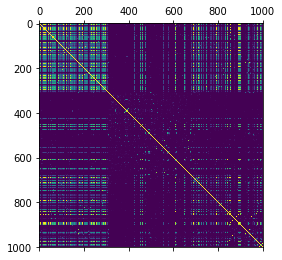

In [11]:
from matplotlib import pyplot as plt
plt.matshow(modcos_sim)

#### Check difference between greedy and hungarian computation:

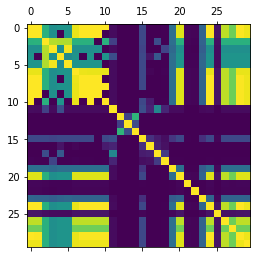

In [13]:
plt.matshow(modcos_sim0[:30,:30])

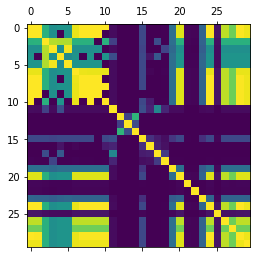

In [12]:
plt.matshow(modcos_sim_greedy[:30,:30])

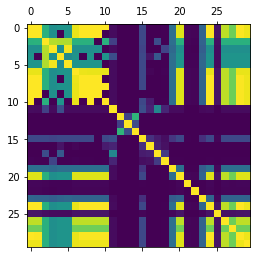

In [24]:
plt.matshow(modcos_sim[:30,:30])

In [15]:
mat_diff = modcos_sim_greedy - modcos_sim0
mat_diff.max(), mat_diff.min()

(0.9043544184552202, 0.0)

In [16]:
np.where(mat_diff > 0.9)

(array([221, 897], dtype=int64), array([897, 221], dtype=int64))

In [17]:
ID1, ID2 = 221, 897
max_mz = 1000.0
tol = 0.005
mass_shift = spectra[ID1].parent_mz - spectra[ID2].parent_mz
print(mass_shift)

spec1 = np.array(spectra[ID1].peaks, dtype=float)
spec1 = spec1[spec1[:,0] < max_mz,:]
spec2 = np.array(spectra[ID2].peaks, dtype=float)
spec2 = spec2[spec2[:,0] < max_mz,:]
#mass_shift = spectra[ID1].parent_mz - spectra[ID2].parent_mz

#MS_sim_classic.find_pairs(spec1, spec2, tol)
MS_sim_classic.cosine_score_greedy(spec1, 
                        spec2,
                        mass_shift,
                        tol, 
                        min_intens = 0,
                        use_numba = False)

217.171


(2.3282994584941852e-05,
 [(112, 5, 1.7059246489623038e-05), (115, 10, 8.686184847698088e-06)])

In [18]:
MS_sim_classic.find_pairs(spec1, spec2, tol, shift = mass_shift)

[(112, 5, 1.7059246489623038e-05), (115, 10, 8.686184847698088e-06)]

In [55]:
spec1[18:21,0], spec2[9:12,0] + mass_shift

(array([225.055695, 252.042999, 253.050598]),
 array([245.614145, 252.972726, 253.053354]))

In [19]:
#MS_sim_classic.find_pairs_numba(spec1, spec2, tol)
MS_sim_classic.cosine_score_greedy(spec1, 
                        spec2,
                        mass_shift,
                        tol, 
                        min_intens = 0,
                        use_numba = True)

(0.9043777014498052,
 [(116, 12, 1.0),
  (51, 5, 1.7059246489623038e-05),
  (101, 10, 8.686184847698088e-06)])

In [21]:
MS_sim_classic.find_pairs_numba(spec1, spec2, tol, shift = mass_shift)

[(51, 5, 1.7059246489623038e-05),
 (101, 10, 8.686184847698088e-06),
 (116, 12, 1.0)]

In [32]:
spec1[[116, 51, 101, 115],0], spec2[[12, 5, 10],0] + mass_shift

(array([341.211212, 295.205505, 323.2005  , 107.085503]),
 array([341.216212, 295.207034, 323.203578]))

In [23]:
np.abs(spec2[:,0] - spec1[51,0] + mass_shift)

array([2.7010594e+01, 2.6007386e+01, 2.4994763e+01, 9.9832510e+00,
       5.2860690e+00, 1.5290000e-03, 1.0096840e+00, 2.0172220e+00,
       1.0450190e+01, 1.8013217e+01, 2.7998073e+01, 4.3993701e+01,
       4.6010707e+01, 4.7012545e+01, 6.2005580e+01])